Prepare Training Data
1. Set up /  Prepare and format the data correctly for input into the model.


In [ ]:
# 1. Set up
!pip install scikit-fuzzy torch numpy seaborn
!pip install tqdm


In [ ]:
import pickle
import random

import torch
import torch.nn                   as nn
import torch.optim                as optim

import torchvision.transforms     as transforms

import numpy                      as np
import seaborn                    as sns
import matplotlib.pyplot          as plt

from tqdm                         import tqdm

from collections                  import Counter

from skfuzzy                      import cmeans
from sklearn.metrics              import confusion_matrix
from sklearn.metrics              import precision_recall_fscore_support
from torch.utils.data             import Dataset, DataLoader
from torch.optim.lr_scheduler     import CosineAnnealingLR
from sklearn.model_selection      import train_test_split

from google.colab import drive
from google.colab import files

In [ ]:
# Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Configuration for easy modification
# Configuration for easy modification
CONFIG = {
    'path9': '/content/drive/MyDrive/Colab Notebooks/Dataset/9.pkl',
    'path8': '/content/drive/MyDrive/Colab Notebooks/Dataset/8.pkl',
    'path7': '/content/drive/MyDrive/Colab Notebooks/Dataset/7.pkl',
    'path6': '/content/drive/MyDrive/Colab Notebooks/Dataset/6.pkl',
    'path5': '/content/drive/MyDrive/Colab Notebooks/Dataset/5.pkl',
    'path4': '/content/drive/MyDrive/Colab Notebooks/Dataset/4.pkl',
    'path3': '/content/drive/MyDrive/Colab Notebooks/Dataset/3.pkl',
    'path2': '/content/drive/MyDrive/Colab Notebooks/Dataset/2.pkl',
    'path1': '/content/drive/MyDrive/Colab Notebooks/Dataset/1.pkl',

    'batch_size':      32,
    'num_epochs':      60,
    'learning_rate':   1e-3,    # halved inside Trainer to 5e-4
    'weight_decay':    1e-5,    # new
    'train_ratio':     0.8,
    'num_classes':     9,
    'hidden_dim':      128,
    'patience':        8,
    'seq_len':         10,
    'class_weights':   [1.0]*9,
    'debug':           True,
    'use_augmentation': False,
    'plot_loss_curves': True,
    'plot_f1_scores':   True,
}

In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Part II: Load the Data
2. Data loading
  - Use pickle to load depth_sequences and labels from disk
  - Or
  - Create a Dataset class and DataLoader to feed the data into the model in batches.

- Requirements:
  - A class that inherits from torch.utils.data.Dataset:
   - __getitem__ returns a sequence of images and the corresponding label.
  - A DataLoader to retrieve batches during training.

In [31]:
import pandas as pd
# Label mapping
label_map = {
    0: 'forward', 1: 'backward', 2: 'up', 3: 'down',
    4: 'left', 5: 'right', 6: 'stop',
    7: 'rotate_left', 8: 'rotate_right'
}

total_counter = Counter()

for i in range(1, 10):
    path = f'/content/drive/MyDrive/Colab Notebooks/Dataset/{i}.pkl'
    label_counter, label_str_counter, total = Counter(), Counter(), 0
    try:
        with open(path, 'rb') as f:
            while True:
                try:
                    frame = pickle.load(f)
                    total += 1
                    label = frame.get("label")
                    label_str = frame.get("label_str")
                    if label is not None: label_counter[label] += 1; total_counter[label] += 1
                    if label_str: label_str_counter[label_str] += 1
                except EOFError: break
        print(f" {i}.pkl | Frames: {total} | Labels: {dict(label_counter)}")
        print(f" Strings: {dict(label_str_counter)}\n")

    except Exception as e:
        print(f" {i}.pkl: {e}")

# Ensure all labels 0–8 exist
for i in range(10): total_counter.setdefault(i, 0)

# Summary table
summary = pd.DataFrame({
    'Label': list(range(9)),
    'Label String': [label_map[i] for i in range(9)],
    'Count': [total_counter[i] for i in range(9)]
})
summary.loc[len(summary.index)] = ['', 'Total', summary['Count'].sum()]
print("\n Summary (sorted by label):")

display(summary)


 1.pkl | Frames: 909 | Labels: {6: 247, 2: 80, 0: 295, 4: 88, 7: 13, 3: 51, 8: 34, 1: 39, 5: 62}
 Strings: {'stop': 247, 'up': 80, 'forward': 295, 'left': 88, 'rotate_left': 13, 'down': 51, 'rotate_right': 34, 'backward': 39, 'right': 62}

 2.pkl | Frames: 1849 | Labels: {6: 175, 7: 166, 0: 745, 2: 140, 4: 116, 8: 104, 1: 142, 5: 125, 3: 136}
 Strings: {'stop': 175, 'rotate_left': 166, 'forward': 745, 'up': 140, 'left': 116, 'rotate_right': 104, 'backward': 142, 'right': 125, 'down': 136}

 3.pkl | Frames: 1729 | Labels: {6: 220, 8: 153, 7: 132, 2: 188, 0: 644, 4: 105, 3: 134, 1: 58, 5: 95}
 Strings: {'stop': 220, 'rotate_right': 153, 'rotate_left': 132, 'up': 188, 'forward': 644, 'left': 105, 'down': 134, 'backward': 58, 'right': 95}

 4.pkl | Frames: 1289 | Labels: {6: 358, 1: 74, 7: 118, 0: 507, 2: 70, 5: 34, 3: 45, 8: 42, 4: 41}
 Strings: {'stop': 358, 'backward': 74, 'rotate_left': 118, 'forward': 507, 'up': 70, 'right': 34, 'down': 45, 'rotate_right': 42, 'left': 41}

 5.pkl | Fr

,Label,Label String,Count
0,0,forward,3944
1,1,backward,518
2,2,up,770
3,3,down,530
4,4,left,476
5,5,right,507
6,6,stop,2036
7,7,rotate_left,741
8,8,rotate_right,656
9,,Total,10178


In [ ]:
def load_depth_sequences_from_pkl(pkl_path, seq_len=10, debug=False):
    """
    Load a .pkl file containing UAV frame data and convert it into sequences for CNN-LSTM training.

    Args:
        pkl_path (str): Path to the .pkl file
        seq_len (int): Number of consecutive frames in a sequence
        debug (bool): If True, prints stats and first sample

    Returns:
        depth_sequences (list of np.array): Shape (N, seq_len, 1, H, W)
        labels (list of int): Corresponding labels for each sequence
    """
    # Load all frames
    frames = []
    with open(pkl_path, "rb") as f:
        try:
            while True:
                frame = pickle.load(f)
                frames.append(frame)
        except EOFError:
            pass

    # Convert to sequences
    depth_sequences = []
    labels = []

    for i in range(len(frames) - seq_len):
        seq = frames[i:i + seq_len]
        # Check all frames in seq are valid and labeled
        if any("depth" not in f or "label" not in f for f in seq):
            continue
        try:
            seq_depths = np.array([f["depth"] for f in seq])  # shape: (seq_len, H, W)
            seq_depths = seq_depths[:, np.newaxis, :, :]      # add channel dim → (seq_len, 1, H, W)
            depth_sequences.append(seq_depths)
            labels.append(seq[-1]["label"])                   # label is based on last frame
        except Exception as e:
            if debug:
                print(f"Skipped sequence at {i} due to error: {e}")

    if debug:
        print(f"Loaded {len(depth_sequences)} sequences of length {seq_len}")
        print("First sequence shape:", depth_sequences[0].shape)
        print("First label:", labels[0])

    return depth_sequences, labels


In [ ]:
depth_seqs, labels = load_depth_sequences_from_pkl(CONFIG["path9"], seq_len=10, debug=True)


Loaded 1395 sequences of length 10
First sequence shape: (10, 1, 256, 256)
First label: 6


# Split Data


In [ ]:
def split_data(depth_sequences, labels, train_ratio=0.8, debug=False):
    """
    Split depth sequences and labels into training and validation sets.

    Args:
        depth_sequences (list of np.array): Input sequences
        labels (list of int): Corresponding labels
        train_ratio (float): Ratio of training data
        debug (bool): Print summary

    Returns:
        X_train, X_val, y_train, y_val
    """
    X_train, X_val, y_train, y_val = train_test_split(
        depth_sequences, labels,
        train_size=train_ratio,
        stratify=labels,  # Ensure balanced label distribution
        random_state=42
    )

    if debug:
        print(f"Training samples: {len(X_train)}")
        print(f"Validation samples: {len(X_val)}")
        print("Train label distribution:", Counter(y_train))
        print("Val label distribution:", Counter(y_val))

    return X_train, X_val, y_train, y_val


In [ ]:
train_sequences, val_sequences, train_labels, val_labels = split_data(depth_seqs, labels, train_ratio=0.8, debug=True)


Training samples: 1116
Validation samples: 279
Train label distribution: Counter({0: 352, 6: 341, 7: 117, 2: 92, 3: 67, 5: 50, 8: 42, 1: 41, 4: 14})
Val label distribution: Counter({0: 88, 6: 86, 7: 30, 2: 23, 3: 17, 5: 12, 8: 10, 1: 10, 4: 3})


# Data Loader

In [ ]:
# 3. Preprocessing
# Data Augmentation for Depth Images
def augment_depth_image(image, debug=False):
    """
    Apply random augmentations to a depth image (H x W).
    Args:
        image (array): Input image [H, W] (or [1, H, W])
        debug (bool): Print debug info if True
    Returns:
        array: Augmented image [H, W]
    """
    # Handle potential (1, H, W) input from some stages
    if len(image.shape) == 3 and image.shape[0] == 1:
        image = image.squeeze(0)

    if len(image.shape) != 2:
         if debug:
             print(f"ERROR: Augmentation received invalid shape {image.shape}, expected 2D.")
         raise ValueError("Invalid image shape for augmentation, expected 2D.")

    # Get original shape
    H, W = image.shape

    # Convert to tensor and add channel dimension → shape: (1, H, W)
    image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)

    # Define augmentation transforms - ensure they work on (1, H, W)
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),
        # Adjust translate based on actual image size, not hardcoded 0.1 for 256
        # Max translation should be a fraction of image size
        # Adjusted translation scale based on 256x256 assumption
        transforms.RandomAffine(degrees=0, translate=(0.1 * (256/W), 0.1 * (256/H))),

        # Add random noise
        transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.01)
    ])

    # Apply transforms
    augmented_image = transform(image)

    # Remove channel dimension → shape: (H, W) and convert back to numpy
    return augmented_image.squeeze(0).numpy()


# Simple Encoder


#Dataset


In [ ]:
class UAVDepthDataset(Dataset):
    def __init__(self, depth_sequences, labels, augment=True, debug=False):
        self.depth_sequences = depth_sequences
        self.labels = labels
        self.augment = augment
        self.debug = debug

        if len(self.depth_sequences) == 0:
            raise ValueError("Empty dataset!")

        # Validate labels
        num_classes = CONFIG.get('num_classes', 9)
        invalid = [l for l in labels if not (0 <= l < num_classes)]
        if invalid:
            raise ValueError(f"Invalid labels: {set(invalid)}; expected in [0,{num_classes-1}]")

    def __len__(self):
        return len(self.depth_sequences)

    def __getitem__(self, idx):
      raw = self.depth_sequences[idx]  # maybe (T,1,1,H,W) or (T,1,H,W)
      seq = []

      if self.augment:
          for frame in raw:
              # frame: (1,1,H,W) or (1,H,W)
              f2d = np.squeeze(frame)                # → (H,W)
              f2d = augment_depth_image(f2d, self.debug)
              seq.append(f2d[np.newaxis, ...])       # → (1,H,W)
      else:
          # just collapse all singleton dims on each frame
          for frame in raw:
              f2d = np.squeeze(frame)                # → (H,W)
              seq.append(f2d[np.newaxis, ...])       # → (1,H,W)

      # Now stack into (T,1,H,W)
      proc = np.stack(seq, axis=0)
      proc = torch.tensor(proc, dtype=torch.float32)  # (T,1,H,W)
      lbl  = torch.tensor(self.labels[idx], dtype=torch.long)
      return proc, lbl


#Load Data

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import ConcatDataset, Subset, DataLoader

train_subsets = []
val_subsets   = []

for i in range(1, 10):
    seqs, labels = load_depth_sequences_from_pkl(
        CONFIG[f'path{i}'], seq_len=CONFIG['seq_len'], debug=CONFIG['debug']
    )
    t_seqs, v_seqs, t_lbls, v_lbls = train_test_split(
        seqs, labels,
        train_size = CONFIG['train_ratio'],
        stratify   = labels,
        random_state = 42
    )
    train_ds = UAVDepthDataset(t_seqs, t_lbls, augment=CONFIG['use_augmentation'], debug=CONFIG['debug'])
    val_ds   = UAVDepthDataset(v_seqs, v_lbls, augment=False, debug=CONFIG['debug'])
    train_subsets.append(train_ds)
    val_subsets.append(val_ds)

# Now merge all the per-file subsets
full_train_ds = ConcatDataset(train_subsets)
full_val_ds   = ConcatDataset(val_subsets)

train_loader = DataLoader(full_train_ds, batch_size=CONFIG["batch_size"], shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(full_val_ds,   batch_size=CONFIG["batch_size"], shuffle=False, num_workers=2, pin_memory=True)


Loaded 899 sequences of length 10
First sequence shape: (10, 1, 256, 256)
First label: 6
Loaded 1839 sequences of length 10
First sequence shape: (10, 1, 256, 256)
First label: 6
Loaded 1719 sequences of length 10
First sequence shape: (10, 1, 256, 256)
First label: 6
Loaded 1279 sequences of length 10
First sequence shape: (10, 1, 256, 256)
First label: 6
Loaded 905 sequences of length 10
First sequence shape: (10, 1, 256, 256)
First label: 6
Loaded 804 sequences of length 10
First sequence shape: (10, 1, 256, 256)
First label: 6
Loaded 604 sequences of length 10
First sequence shape: (10, 1, 256, 256)
First label: 6
Loaded 644 sequences of length 10
First sequence shape: (10, 1, 256, 256)
First label: 6
Loaded 1395 sequences of length 10
First sequence shape: (10, 1, 256, 256)
First label: 6


In [ ]:
class Attention(nn.Module):
    """
    Simple attention mechanism over time dimension.
    Input: x of shape (B, T, hidden_dim)
    Output: context vector of shape (B, hidden_dim)
    """
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # x: (B, T, hidden_dim)
        weights = self.attn(x)          # (B, T, 1)
        weights = self.softmax(weights) # (B, T, 1)
        context = torch.sum(weights * x, dim=1)  # (B, hidden_dim)
        return context


#Efficient Model


In [ ]:
import torch
import torch.nn as nn
import torch.nn.utils as nn_utils
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from typing import Tuple

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int,
                 kernel_size: int = 3, padding: int = 1,
                 num_groups: int = 8):
        super().__init__()
        # depthwise
        self.depthwise = nn.Conv2d(
            in_channels, in_channels,
            kernel_size=kernel_size,
            padding=padding,
            groups=in_channels,
            bias=False
        )
        # pointwise
        self.pointwise = nn.Conv2d(
            in_channels, out_channels,
            kernel_size=1,
            bias=False
        )
        # use GroupNorm for small‐batch stability
        self.gn = nn.GroupNorm(num_groups=min(num_groups, out_channels),
                               num_channels=out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.gn(x)
        return self.relu(x)

class EfficientCNNEncoder(nn.Module):
    def __init__(self, in_channels: int = 1, out_channels: int = 8):
        super().__init__()
        self.encoder = nn.Sequential(
            DepthwiseSeparableConv(in_channels, 16),
            DepthwiseSeparableConv(16,          out_channels),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.encoder(x)

In [ ]:
class EfficientUAVNavigationModel(nn.Module):
    def __init__(
        self,
        num_classes: int            = 9,
        hidden_dim:   int            = 128,
        encoder_out:  int            = 8,
        image_size:   Tuple[int,int] = (256, 256),
        debug:        bool           = False
    ):
        super().__init__()
        self.debug = debug

        # -- spatial encoder --
        self.encoder = EfficientCNNEncoder(in_channels=1,
                                           out_channels=encoder_out)
        self.cnn = nn.Sequential(
            DepthwiseSeparableConv(encoder_out, 64),
            nn.MaxPool2d(2),
            DepthwiseSeparableConv(64,         128),
            nn.MaxPool2d(2),
        )

        # -- check downsampling is ≥2×2 --
        # run a dummy tensor through to verify
        with torch.no_grad():
            dummy = torch.zeros(1, encoder_out, *image_size)
            feat  = self.cnn(dummy)
            Hf, Wf = feat.shape[-2], feat.shape[-1]
            assert Hf >= 2 and Wf >= 2, \
                f"Feature map {Hf}×{Wf} too small for 2×2 SPP"

        # -- spatial pyramid pooling into 2×2 bins --
        self.spp = nn.AdaptiveAvgPool2d((2, 2))  # outputs (B*T, 128, 2, 2)

        # -- projection down to GRU input dim --
        self.proj    = nn.Linear(128 * 4, 128)
        self.dropout = nn.Dropout(p=0.3)

        # -- temporal model --
        self.gru = nn.GRU(
            input_size=128,
            hidden_size=hidden_dim,
            batch_first=True
        )

        # -- attention & final classifier --
        self.attn    = nn.Linear(hidden_dim, 1)
        self.softmax = nn.Softmax(dim=1)
        self.fc      = nn.Linear(hidden_dim, num_classes)

        # initialize weights
        self._init_weights()


    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.GRU):
                # leave GRU defaults or add custom init here if desired
                pass

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, T, 1, H, W)
        returns logits: (B, num_classes)
        """
        B, T, C, H, W = x.shape
        # merge batch & time dims
        x = x.view(B * T, C, H, W)           # → (B*T, 1, H, W)

        # spatial features
        x = self.encoder(x)                  # → (B*T, encoder_out, H, W)
        x = self.cnn(x)                      # → (B*T, 128, H', W')

        # 2×2 spatial pyramid pooling
        x = self.spp(x)                      # → (B*T, 128, 2, 2)
        x = x.view(B, T, 128 * 4)            # → (B, T, 512)

        # project & dropout
        x = self.proj(x)                     # → (B, T, 128)
        x = self.dropout(x)

        # temporal modeling
        x, _ = self.gru(x)                   # → (B, T, hidden_dim)

        # attention pooling
        weights = self.attn(x)               # → (B, T, 1)
        weights = self.softmax(weights)      # → (B, T, 1)
        context = torch.sum(weights * x, dim=1)  # → (B, hidden_dim)

        # classification
        logits = self.fc(context)            # → (B, num_classes)

        if self.debug:
            print(f"[forward] logits.shape = {logits.shape}")

        return logits

#Part IV: Loss Function and Optimization
- Set up:
  - Loss Function: e.g., CrossEntropyLoss for classification tasks.
  - Optimizer: e.g., Adam, SGD.
  - Learning Rate, Epoch, Batch size.

In [ ]:
# Initialize model
print("Initializing model...")
model = EfficientUAVNavigationModel(
    num_classes=CONFIG['num_classes'],
    hidden_dim=CONFIG['hidden_dim'],
    debug = False
)

Initializing model...


In [ ]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, config):
        self.device       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model        = model.to(self.device)
        self.train_loader = train_loader
        self.val_loader   = val_loader
        self.config       = config

        # sanity checks
        if len(train_loader)==0 or len(val_loader)==0:
            raise ValueError("Empty DataLoader!")

        cw = torch.tensor(config['class_weights'],
                          device=self.device, dtype=torch.float32)
        self.criterion = nn.CrossEntropyLoss(weight=cw)

        # ← smaller LR + weight decay
        self.optimizer = optim.Adam(
            self.model.parameters(),
            lr=config['learning_rate'] * 0.5,    # e.g. 1e-3 → 5e-4
            weight_decay=1e-5
        )
        self.scheduler = CosineAnnealingLR(
            self.optimizer,
            T_max=config['num_epochs'],
            eta_min=1e-6
        )

        self.train_losses     = []
        self.val_losses       = []
        self.train_accuracies = []
        self.val_accuracies   = []

    def train_epoch(self):
        self.model.train()
        total_loss, correct, total = 0., 0, 0

        for inputs, labels in self.train_loader:
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()

            outputs = self.model(inputs)
            loss    = self.criterion(outputs, labels)
            loss.backward()

            # ← gradient clipping
            nn_utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()

            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds==labels).sum().item()
            total   += labels.size(0)

        avg_loss = total_loss / len(self.train_loader)
        acc      = 100 * correct / max(total,1)
        return avg_loss, acc

    def validate_epoch(self):
        self.model.eval()
        total_loss, correct, total = 0., 0, 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for inputs, labels in self.val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss    = self.criterion(outputs, labels)

                total_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += (preds==labels).sum().item()
                total   += labels.size(0)

                all_preds.extend(preds.cpu().tolist())
                all_labels.extend(labels.cpu().tolist())

        avg_loss = total_loss / len(self.val_loader)
        acc      = 100 * correct / max(total,1)
        return avg_loss, acc, all_preds, all_labels

    def plot_learning_curves(self):
        epochs = range(1, len(self.train_losses)+1)
        plt.figure(figsize=(12,4))
        plt.subplot(1,2,1)
        plt.plot(epochs, self.train_losses, label='Train Loss')
        plt.plot(epochs, self.val_losses,   label='Val Loss')
        plt.title('Loss Curves'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

        plt.subplot(1,2,2)
        plt.plot(epochs, self.train_accuracies, label='Train Acc')
        plt.plot(epochs, self.val_accuracies,   label='Val Acc')
        plt.title('Accuracy Curves'); plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.legend()
        plt.tight_layout()
        plt.show()

    def evaluate(self, labels, preds):
        precision, recall, f1, _ = precision_recall_fscore_support(
            labels, preds, average=None,
            labels=list(range(self.config['num_classes'])),
            zero_division=0
        )
        macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(
            labels, preds, average='macro', zero_division=0
        )
        cm = confusion_matrix(labels, preds,
                              labels=list(range(self.config['num_classes'])))

        action_names = [
            "Forward","Up","Down","Left","Right","Stop",
            "Rotate Left","Rotate Right","Backward"
        ]
        print("\nPer-class metrics:")
        for i in range(self.config['num_classes']):
            name = action_names[i] if i<len(action_names) else f"Class_{i}"
            print(f"{name}: P={precision[i]:.2f}, R={recall[i]:.2f}, F1={f1[i]:.2f}")
        print(f"Macro F1: {macro_f1:.2f}")

        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=action_names[:self.config['num_classes']],
                    yticklabels=action_names[:self.config['num_classes']])
        plt.title("Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("True")
        plt.show()

        return {
            'precision': precision.tolist(),
            'recall': recall.tolist(),
            'f1': f1.tolist(),
            'macro_f1': macro_f1,
            'confusion_matrix': cm.tolist()
        }

    def train(self):
        best_loss = float('inf')
        no_improve = 0

        for epoch in tqdm(range(self.config['num_epochs']), desc="Epochs"):
            train_l, train_acc = self.train_epoch()
            val_l, val_acc, preds, labels = self.validate_epoch()

            self.train_losses.append(train_l)
            self.val_losses.append(val_l)
            self.train_accuracies.append(train_acc)
            self.val_accuracies.append(val_acc)

            # step scheduler once per epoch
            self.scheduler.step()

            print(f"Epoch {epoch+1}: "
                  f"Train L={train_l:.3f}, A={train_acc:.1f}% | "
                  f"Val L={val_l:.3f}, A={val_acc:.1f}%")

            if val_l < best_loss:
                best_loss = val_l
                torch.save(self.model.state_dict(), "best_model.pt")
                no_improve = 0
            else:
                no_improve += 1

            if no_improve >= self.config['patience']:
                print("Early stopping triggered.")
                break

        # Final evaluation
        print("\n--- Final Evaluation ---")
        _, _, preds, labels = self.validate_epoch()
        results = self.evaluate(labels, preds)
        self.plot_learning_curves()
        return results

Epochs:   2%|▏         | 1/60 [01:33<1:32:12, 93.77s/it]

Epoch 1: Train L=1.782, A=39.9% | Val L=1.754, A=38.8%


Epochs:   3%|▎         | 2/60 [03:05<1:29:37, 92.71s/it]

Epoch 2: Train L=1.659, A=43.1% | Val L=1.603, A=43.2%


Epochs:   5%|▌         | 3/60 [04:37<1:27:49, 92.44s/it]

Epoch 3: Train L=1.563, A=45.0% | Val L=1.561, A=44.6%


Epochs:   7%|▋         | 4/60 [06:10<1:26:10, 92.33s/it]

Epoch 4: Train L=1.479, A=47.5% | Val L=1.437, A=50.3%


Epochs:   8%|▊         | 5/60 [07:42<1:24:33, 92.24s/it]

Epoch 5: Train L=1.383, A=50.8% | Val L=1.319, A=52.2%


Epochs:  10%|█         | 6/60 [09:14<1:22:58, 92.19s/it]

Epoch 6: Train L=1.302, A=53.7% | Val L=1.274, A=54.7%


Epochs:  12%|█▏        | 7/60 [10:46<1:21:25, 92.18s/it]

Epoch 7: Train L=1.213, A=56.5% | Val L=1.156, A=57.2%


Epochs:  13%|█▎        | 8/60 [12:18<1:19:51, 92.15s/it]

Epoch 8: Train L=1.115, A=59.6% | Val L=1.054, A=64.0%


Epochs:  15%|█▌        | 9/60 [13:50<1:18:19, 92.15s/it]

Epoch 9: Train L=1.019, A=63.6% | Val L=0.967, A=65.9%


Epochs:  17%|█▋        | 10/60 [15:22<1:16:46, 92.13s/it]

Epoch 10: Train L=0.934, A=66.8% | Val L=0.910, A=68.3%


Epochs:  18%|█▊        | 11/60 [16:54<1:15:14, 92.12s/it]

Epoch 11: Train L=0.865, A=70.1% | Val L=0.819, A=72.3%


Epochs:  20%|██        | 12/60 [18:26<1:13:41, 92.12s/it]

Epoch 12: Train L=0.795, A=72.9% | Val L=0.794, A=73.8%


Epochs:  22%|██▏       | 13/60 [19:59<1:12:09, 92.12s/it]

Epoch 13: Train L=0.741, A=74.0% | Val L=0.727, A=76.1%


Epochs:  23%|██▎       | 14/60 [21:31<1:10:37, 92.12s/it]

Epoch 14: Train L=0.682, A=76.3% | Val L=0.681, A=76.0%


Epochs:  25%|██▌       | 15/60 [23:03<1:09:05, 92.13s/it]

Epoch 15: Train L=0.631, A=78.2% | Val L=0.614, A=80.3%


Epochs:  27%|██▋       | 16/60 [24:35<1:07:33, 92.13s/it]

Epoch 16: Train L=0.584, A=79.9% | Val L=0.598, A=81.3%


Epochs:  28%|██▊       | 17/60 [26:07<1:06:00, 92.11s/it]

Epoch 17: Train L=0.545, A=81.1% | Val L=0.553, A=80.9%


Epochs:  30%|███       | 18/60 [27:39<1:04:29, 92.13s/it]

Epoch 18: Train L=0.511, A=82.5% | Val L=0.553, A=81.2%


Epochs:  32%|███▏      | 19/60 [29:11<1:02:57, 92.14s/it]

Epoch 19: Train L=0.468, A=84.5% | Val L=0.519, A=82.3%


Epochs:  33%|███▎      | 20/60 [30:43<1:01:24, 92.12s/it]

Epoch 20: Train L=0.448, A=85.0% | Val L=0.465, A=85.5%


Epochs:  35%|███▌      | 21/60 [32:15<59:52, 92.11s/it]  

Epoch 21: Train L=0.416, A=86.0% | Val L=0.456, A=85.3%


Epochs:  37%|███▋      | 22/60 [33:48<58:20, 92.12s/it]

Epoch 22: Train L=0.397, A=86.5% | Val L=0.456, A=85.3%


Epochs:  38%|███▊      | 23/60 [35:20<56:49, 92.15s/it]

Epoch 23: Train L=0.376, A=87.2% | Val L=0.415, A=86.5%


Epochs:  40%|████      | 24/60 [36:52<55:16, 92.13s/it]

Epoch 24: Train L=0.349, A=88.3% | Val L=0.388, A=87.8%


Epochs:  42%|████▏     | 25/60 [38:24<53:44, 92.12s/it]

Epoch 25: Train L=0.335, A=88.7% | Val L=0.447, A=84.6%


Epochs:  43%|████▎     | 26/60 [39:56<52:11, 92.09s/it]

Epoch 26: Train L=0.314, A=89.0% | Val L=0.388, A=88.2%


Epochs:  45%|████▌     | 27/60 [41:28<50:39, 92.10s/it]

Epoch 27: Train L=0.306, A=89.5% | Val L=0.383, A=87.2%


Epochs:  47%|████▋     | 28/60 [43:00<49:07, 92.11s/it]

Epoch 28: Train L=0.294, A=90.0% | Val L=0.381, A=87.1%


Epochs:  48%|████▊     | 29/60 [44:32<47:35, 92.12s/it]

Epoch 29: Train L=0.281, A=90.1% | Val L=0.336, A=88.7%


Epochs:  50%|█████     | 30/60 [46:05<46:04, 92.14s/it]

Epoch 30: Train L=0.266, A=90.9% | Val L=0.343, A=88.6%


Epochs:  52%|█████▏    | 31/60 [47:37<44:32, 92.15s/it]

Epoch 31: Train L=0.263, A=90.9% | Val L=0.314, A=88.8%


Epochs:  53%|█████▎    | 32/60 [49:09<42:59, 92.14s/it]

Epoch 32: Train L=0.249, A=91.4% | Val L=0.331, A=88.8%


Epochs:  55%|█████▌    | 33/60 [50:41<41:28, 92.18s/it]

Epoch 33: Train L=0.236, A=91.9% | Val L=0.301, A=89.5%


Epochs:  57%|█████▋    | 34/60 [52:13<39:55, 92.14s/it]

Epoch 34: Train L=0.235, A=92.0% | Val L=0.321, A=88.9%


Epochs:  58%|█████▊    | 35/60 [53:45<38:22, 92.10s/it]

Epoch 35: Train L=0.215, A=92.7% | Val L=0.305, A=90.0%


Epochs:  60%|██████    | 36/60 [55:17<36:49, 92.06s/it]

Epoch 36: Train L=0.209, A=92.6% | Val L=0.295, A=89.7%


Epochs:  62%|██████▏   | 37/60 [56:49<35:17, 92.06s/it]

Epoch 37: Train L=0.206, A=93.0% | Val L=0.281, A=90.2%


Epochs:  63%|██████▎   | 38/60 [58:21<33:45, 92.07s/it]

Epoch 38: Train L=0.199, A=93.0% | Val L=0.274, A=91.1%


Epochs:  65%|██████▌   | 39/60 [59:53<32:13, 92.09s/it]

Epoch 39: Train L=0.189, A=93.7% | Val L=0.260, A=91.4%


Epochs:  67%|██████▋   | 40/60 [1:01:26<30:41, 92.07s/it]

Epoch 40: Train L=0.186, A=93.7% | Val L=0.254, A=91.6%


Epochs:  68%|██████▊   | 41/60 [1:02:58<29:08, 92.05s/it]

Epoch 41: Train L=0.180, A=94.0% | Val L=0.269, A=90.9%


Epochs:  70%|███████   | 42/60 [1:04:30<27:36, 92.03s/it]

Epoch 42: Train L=0.168, A=94.4% | Val L=0.249, A=92.0%


Epochs:  72%|███████▏  | 43/60 [1:06:02<26:04, 92.05s/it]

Epoch 43: Train L=0.164, A=94.5% | Val L=0.235, A=92.2%


Epochs:  73%|███████▎  | 44/60 [1:07:34<24:32, 92.03s/it]

Epoch 44: Train L=0.155, A=94.6% | Val L=0.230, A=92.0%


Epochs:  75%|███████▌  | 45/60 [1:09:06<23:00, 92.01s/it]

Epoch 45: Train L=0.151, A=95.2% | Val L=0.237, A=92.3%


Epochs:  77%|███████▋  | 46/60 [1:10:38<21:28, 92.00s/it]

Epoch 46: Train L=0.149, A=95.0% | Val L=0.237, A=92.0%


Epochs:  78%|███████▊  | 47/60 [1:12:10<19:56, 92.00s/it]

Epoch 47: Train L=0.146, A=95.2% | Val L=0.228, A=92.1%


Epochs:  80%|████████  | 48/60 [1:13:42<18:24, 92.01s/it]

Epoch 48: Train L=0.143, A=95.4% | Val L=0.225, A=92.0%


Epochs:  82%|████████▏ | 49/60 [1:15:13<16:51, 91.98s/it]

Epoch 49: Train L=0.138, A=95.7% | Val L=0.218, A=92.2%


Epochs:  83%|████████▎ | 50/60 [1:16:45<15:19, 91.95s/it]

Epoch 50: Train L=0.137, A=95.6% | Val L=0.215, A=92.8%


Epochs:  85%|████████▌ | 51/60 [1:18:17<13:47, 91.92s/it]

Epoch 51: Train L=0.133, A=95.8% | Val L=0.221, A=92.2%


Epochs:  87%|████████▋ | 52/60 [1:19:49<12:15, 91.92s/it]

Epoch 52: Train L=0.131, A=95.5% | Val L=0.213, A=92.8%


Epochs:  88%|████████▊ | 53/60 [1:21:21<10:43, 91.94s/it]

Epoch 53: Train L=0.127, A=96.0% | Val L=0.212, A=92.8%


Epochs:  90%|█████████ | 54/60 [1:22:53<09:11, 91.96s/it]

Epoch 54: Train L=0.127, A=95.9% | Val L=0.214, A=92.6%


Epochs:  92%|█████████▏| 55/60 [1:24:25<07:39, 91.97s/it]

Epoch 55: Train L=0.124, A=96.2% | Val L=0.215, A=92.4%


Epochs:  93%|█████████▎| 56/60 [1:25:57<06:07, 91.92s/it]

Epoch 56: Train L=0.126, A=96.1% | Val L=0.211, A=92.7%


Epochs:  95%|█████████▌| 57/60 [1:27:29<04:35, 91.90s/it]

Epoch 57: Train L=0.123, A=96.0% | Val L=0.210, A=92.7%


Epochs:  97%|█████████▋| 58/60 [1:29:01<03:03, 91.91s/it]

Epoch 58: Train L=0.121, A=96.4% | Val L=0.210, A=92.6%


Epochs:  98%|█████████▊| 59/60 [1:30:33<01:31, 91.91s/it]

Epoch 59: Train L=0.118, A=96.2% | Val L=0.209, A=92.7%


Epochs: 100%|██████████| 60/60 [1:32:05<00:00, 92.08s/it]

Epoch 60: Train L=0.121, A=96.2% | Val L=0.209, A=92.6%

--- Final Evaluation ---



Per-class metrics:
Forward: P=0.95, R=0.94, F1=0.94
Up: P=0.96, R=0.93, F1=0.95
Down: P=0.96, R=0.90, F1=0.93
Left: P=0.90, R=0.96, F1=0.93
Right: P=0.86, R=0.84, F1=0.85
Stop: P=0.94, R=0.90, F1=0.92
Rotate Left: P=0.89, R=0.94, F1=0.92
Rotate Right: P=0.88, R=0.92, F1=0.90
Backward: P=0.96, R=0.91, F1=0.93
Macro F1: 0.92


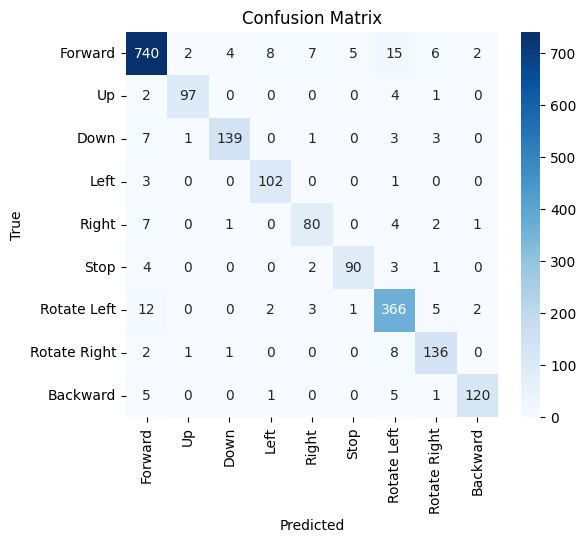

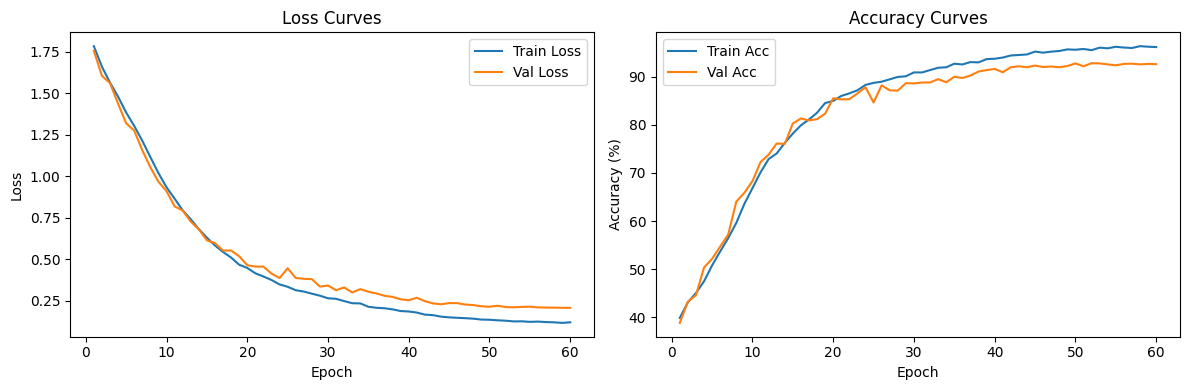

Final eval results: {'precision': [0.9462915601023018, 0.9603960396039604, 0.9586206896551724, 0.9026548672566371, 0.8602150537634409, 0.9375, 0.8948655256723717, 0.8774193548387097, 0.96], 'recall': [0.9378960709759189, 0.9326923076923077, 0.9025974025974026, 0.9622641509433962, 0.8421052631578947, 0.9, 0.9360613810741688, 0.918918918918919, 0.9090909090909091], 'f1': [0.9420751113940166, 0.9463414634146341, 0.9297658862876255, 0.9315068493150684, 0.851063829787234, 0.9183673469387755, 0.915, 0.8976897689768977, 0.933852140077821], 'macro_f1': 0.9184069329102305, 'confusion_matrix': [[740, 2, 4, 8, 7, 5, 15, 6, 2], [2, 97, 0, 0, 0, 0, 4, 1, 0], [7, 1, 139, 0, 1, 0, 3, 3, 0], [3, 0, 0, 102, 0, 0, 1, 0, 0], [7, 0, 1, 0, 80, 0, 4, 2, 1], [4, 0, 0, 0, 2, 90, 3, 1, 0], [12, 0, 0, 2, 3, 1, 366, 5, 2], [2, 1, 1, 0, 0, 0, 8, 136, 0], [5, 0, 0, 1, 0, 0, 5, 1, 120]]}


In [ ]:
# 3) Pass the loaders—not the raw lists—into your Trainer
trainer = Trainer(model, train_loader, val_loader, CONFIG)

# 4) Train!
results = trainer.train()
print("Final eval results:", results)

In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [ ]:
torch.cuda.empty_cache()


In [ ]:
print(torch.cuda.memory_summary(device=0, abbreviated=False))


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 1         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  19412 KiB |  19412 KiB |   1050 TiB |   1050 TiB |
|       from large pool |  16640 KiB |  16640 KiB |   1050 TiB |   1050 TiB |
|       from small pool |   2772 KiB |   2772 KiB |      0 TiB |      0 TiB |
|---------------------------------------------------------------------------|
| Active memory         |  19412 KiB |  19412 KiB |   1050 TiB |   1050 TiB |
|       from large pool |  16640 KiB |  16640 KiB |   1050 TiB |

In [ ]:
torch.cuda.reset_peak_memory_stats()


In [ ]:
# Download the model
print("Training complete. Downloading best_model.pt...")
files.download('/content/best_model.pt')

Training complete. Downloading best_model.pt...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>